# Import lib

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
from vietocr.tool.predictor import Predictor
from vietocr.tool.translate import build_model, process_input
from vietocr.tool.config import Cfg
from torch.nn.functional import log_softmax, softmax

import numpy as np
import torch

# Load model

In [9]:
config = Cfg.load_config_from_file('../config/vietocr_seq2seq_config.yaml')

config['weights'] = '../checkpoint/vgg_seq2seq.pth'
config['cnn']['pretrained']=False
config['device'] = 'cuda'

model, vocab = build_model(config)
model.load_state_dict(torch.load(config['weights'], map_location=torch.device(config['device'])))
model.eval()


/tmp/ipykernel_44390/1020464490.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config['weights'], map_location=torch.device(config['dev

VietOCR(
  (cnn): CNN(
    (model): Vgg(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): AvgPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0)
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): ReLU(inplace=True)
        (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (12): ReLU(inplace=True)
        (13): AvgPool2d(kernel_size=[

# Load image

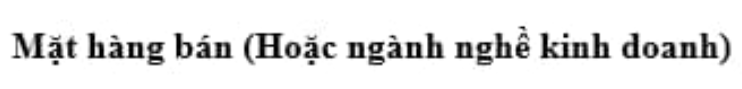

In [10]:
img = Image.open("../asset/test.png")
img

In [11]:
img = process_input(img, config['dataset']['image_height'], 
                config['dataset']['image_min_width'], config['dataset']['image_max_width'])     
img = img.to(config['device'])

# Inference

In [15]:
max_seq_length=128
sos_token=1
eos_token=2
with torch.no_grad():
    src = model.cnn(img) 
    memory = model.transformer.forward_encoder(src)

    translated_sentence = [[sos_token]*len(img)]
    char_probs = [[1]*len(img)]

    max_length = 0

    while max_length <= max_seq_length and not all(np.any(np.asarray(translated_sentence).T==eos_token, axis=1)):

        tgt_inp = torch.LongTensor(translated_sentence).to(config['device'])
        
        output, memory = model.transformer.forward_decoder(tgt_inp, memory)
        output = softmax(output, dim=-1)
        output = output.to('cpu')

        values, indices  = torch.topk(output, 5)
        
        indices = indices[:, -1, 0]
        indices = indices.tolist()
        
        
        values = values[:, -1, 0]
        values = values.tolist()
        char_probs.append(values)

        translated_sentence.append(indices)   
        max_length += 1

        del output

    translated_sentence = np.asarray(translated_sentence).T
    
    char_probs = np.asarray(char_probs).T
    char_probs = np.multiply(char_probs, translated_sentence>3)
    char_probs = np.sum(char_probs, axis=-1)/(char_probs>0).sum(-1)

translated_sentence = translated_sentence[0].tolist()
print(translated_sentence)
s = vocab.decode(translated_sentence)
print("Text: ", s)

[1, 97, 26, 144, 232, 76, 6, 98, 74, 232, 40, 12, 98, 232, 207, 77, 100, 26, 42, 232, 98, 74, 6, 98, 76, 232, 98, 74, 76, 62, 232, 92, 78, 98, 76, 232, 44, 100, 4, 98, 76, 208, 2]
Text:  Mặt hàng bán (Hoặc ngành nghề kinh doanh)
